Here I'm going to test acoustic tracking with a single bat using a simple audio file with the POSIX stamp 1532807201 - the corresponding video file is : 2018-07-28/P00/K1,2,3 00035000.TMC.

This is a 16 channel recording split over 2 Fireface UC's, with 8 channels each. All SANKEN's were on channels 9-12 (1-4 of the second device). 

### The max input level could be different across the SANKEN channels. 
2 channels were probably fed into the instrument in, and 2 channels were fed into the XLR. I need to be aware of this as in the Fireface802, the max input level is different when in the same input port the XLR and instrument line are used. 

For the Fireface UC, the first 2 channels when used as XLR has a max input of 10 dBu @0 dB gain, while when used with instrument has a max input of 21 dBu @0 dB gain. Channels 3-4 (as well as channels 5-8) with the instrument inputs has a max input level of 19 dBu @ 0 dB gain. 

While it may not make such a big difference for the acoustic tracking right now - it might become important later on. 

In [1]:
import batracker
import numpy as np 
import scipy.signal as signal 
import scipy.spatial as spl
import matplotlib.pyplot as plt 
import soundfile as sf
import glob

In [2]:
import batracker
from batracker.localisation import friedlander_1987 as fr87
from batracker.localisation import schau_robinson_1987 as sr87

from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
from batracker.signal_detection.detection import cross_channel_threshold_detector
from batracker.signal_detection.detection import envelope_detector
from batracker.tdoa_estimation.tdoa_estimators import measure_tdoa
from batracker.correspondence_matching.multichannel_match import generate_crosscor_boundaries

In [3]:
%matplotlib notebook

In [4]:
timestamp = '1532807201'
audio_folder= 'E://fieldwork_2018_002//actrackdata//wav//2018-07-28_001//'
audio_file =  glob.glob(audio_folder+'*'+timestamp+'.WAV')
audio_file

# get the first 1 second of the file:
fs = 192000
part_audio = sf.read(audio_file[0])[0][:fs]
# choose 0-3
subset_channels = [8,9,10,11]
part_tristar_channels = part_audio[:,subset_channels] # The channels holding SANKEN 9,10,11,12

In [5]:
part_audio.shape

(192000, 16)

In [6]:
part_audio.shape

(192000, 16)

In [7]:
sf.write('part_ch1-4_120tristar_'+timestamp+'.wav',part_tristar_channels,fs)

In [8]:
fs = 192000

In [9]:
rawpart_tristar_channels, fs = sf.read('part_ch1-4_120tristar_1532807201.wav')

b,a = signal.butter(2, np.array([25000,95000])/(fs*0.5),'bandpass')
part_tristar_channels = np.apply_along_axis(lambda X: signal.filtfilt(b,a,X), 0,rawpart_tristar_channels)

<IPython.core.display.Javascript object>


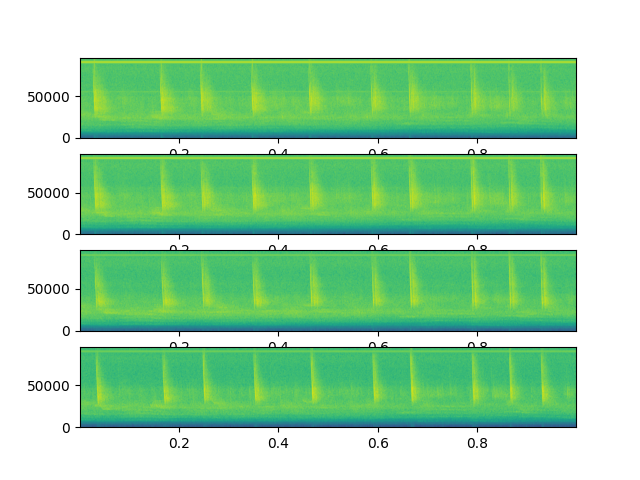

In [10]:
plt.figure()
a0 = plt.subplot(411)
for i in range(4):
    plotid = 411 +i
    if not plotid == 411:
        plt.subplot(plotid, sharex=a0)
    else:
        plt.subplot(plotid)
    plt.specgram(part_tristar_channels[:,i], Fs=fs, NFFT=256,noverlap=192)

<IPython.core.display.Javascript object>


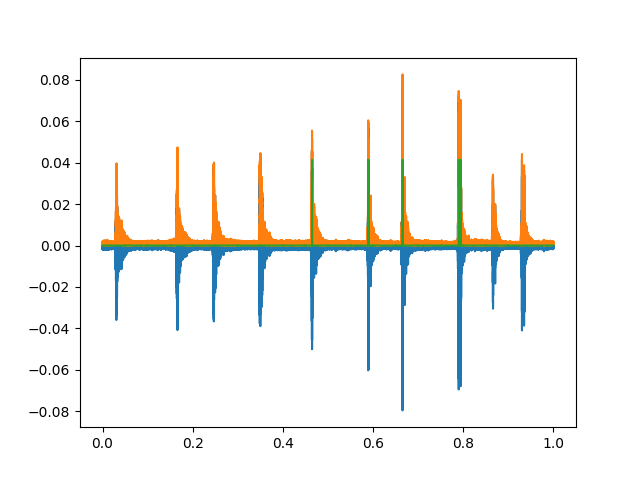

In [11]:

t = np.linspace(0,part_tristar_channels.shape[0]/fs,part_tristar_channels.shape[0])
ch_ind = 1
envelope = abs(signal.hilbert(part_tristar_channels[:,ch_ind]))
fivepctile = np.percentile(20*np.log10(envelope),5)
x_db = 40
xdb_aboe = fivepctile + x_db
level = 10**(xdb_aboe/20.0)
plt.figure()
plt.plot(t, part_tristar_channels[:,ch_ind])
plt.plot(t, envelope)
plt.plot(t, (envelope>level)*np.max(envelope)*0.5)

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 51.20it/s]

4 96000


<IPython.core.display.Javascript object>


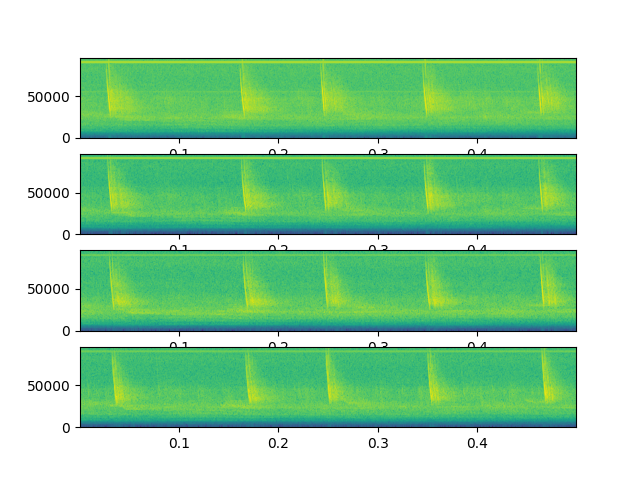

In [12]:
# code taken from the example in https://batracker.readthedocs.io/en/latest/prototyping/plot_start_to_end.html
audio = part_tristar_channels.copy()[:int(fs*0.5)] 
#detections = cross_channel_threshold_detector(audio, fs,
#                                              dbrms_window=2.5*10**-3,
#                                              dbrms_threshold=-47)

detections = cross_channel_threshold_detector(audio, fs,
                                              detector_function=envelope_detector,
                                              threshold_db_floor=40,
                                              lowpass_durn=0.002)
                                              
# Spectrogram of the cross-corr boundaries
plt.figure()
ax= plt.subplot(411)
plt.specgram(audio[:,0], Fs=fs)
for each in detections[0]:
    plt.vlines(each, 0, fs*0.5, linewidth=0.4)

for i in range(2,5):
    plt.subplot(410+i, sharex=ax)
    plt.specgram(audio[:,i-1], Fs=fs)
    for each in detections[i-1]:
        plt.vlines(each, 0, fs*0.5, linewidth=0.4)


In [13]:
manual_crosscor_boundaries = [(0.0238, 0.037), (0.16, 0.17), 
                              (0.241, 0.251), (0.343, 0.353),
                             (0.460, 0.468)]

In [14]:
import copy

In [15]:
## What we expect it to be theoretically
R = 1.2 # meters
theta = np.pi/3
other_x_position = 0.5
theta2 = np.arctan(other_x_position/(R*np.cos(theta)))
R_2 = np.sqrt(other_x_position**2 +  (R*np.cos(theta))**2)
mic_positions = np.array([[0,0,0],
                          [R_2*np.sin(theta2),  0, -R*np.cos(theta), ],
                          [-R*np.sin(theta), 0, -R*np.cos(theta)],
                          [0,0,R]])

ag = pd.DataFrame(mic_positions)
ag.columns  = ['x','y','z']

In [16]:
R_2

0.7810249675906655

In [17]:
np.degrees(theta2)

39.80557109226519

In [18]:
#generate the distance matrix and compare it with the mic positions from video tracking 


In [19]:
2.01846097/2

1.009230485

In [20]:
video_mic_positions = pd.read_csv('video_tracking/mic_positions_video/DLTdv7_data_mics9-12positionsxyzpts.csv')
mic_xyz = video_mic_positions[~pd.isna(video_mic_positions['pt1_X'])].reset_index(drop=True)
mic_xyz.columns=['x','y','z']
mic_xyz

,x,y,z
0,-0.162229,-3.854878,0.097387
1,-1.084803,-3.256231,-0.437829
2,0.278436,-4.036286,-0.544380
3,-0.118366,-3.985202,1.299513


In [21]:
spl.distance_matrix(mic_xyz,mic_xyz)

array([[0.        , 1.22310146, 0.79934935, 1.20996497],
       [1.22310146, 0.        , 1.57424887, 2.11748823],
       [0.79934935, 1.57424887, 0.        , 1.88679697],
       [1.20996497, 2.11748823, 1.88679697, 0.        ]])

In [22]:
spl.distance_matrix(mic_positions,mic_positions)


array([[0.        , 0.78102497, 1.2       , 1.2       ],
       [0.78102497, 0.        , 1.53923048, 1.86815417],
       [1.2       , 1.53923048, 0.        , 2.07846097],
       [1.2       , 1.86815417, 2.07846097, 0.        ]])

In [23]:
spl.distance_matrix(mic_xyz,mic_xyz)-spl.distance_matrix(mic_positions,mic_positions)


array([[ 0.        ,  0.44207649, -0.40065065,  0.00996497],
       [ 0.44207649,  0.        ,  0.03501838,  0.24933406],
       [-0.40065065,  0.03501838,  0.        , -0.191664  ],
       [ 0.00996497,  0.24933406, -0.191664  ,  0.        ]])

In [24]:
#crosscor_boundaries = generate_crosscor_boundaries(final_detections, ag)

crosscor_boundaries = manual_crosscor_boundaries

num_channels = audio.shape[1]

In [25]:
crosscor_boundaries

[(0.0238, 0.037), (0.16, 0.17), (0.241, 0.251), (0.343, 0.353), (0.46, 0.468)]

In [26]:
manual_crosscor_boundaries

[(0.0238, 0.037), (0.16, 0.17), (0.241, 0.251), (0.343, 0.353), (0.46, 0.468)]

<IPython.core.display.Javascript object>


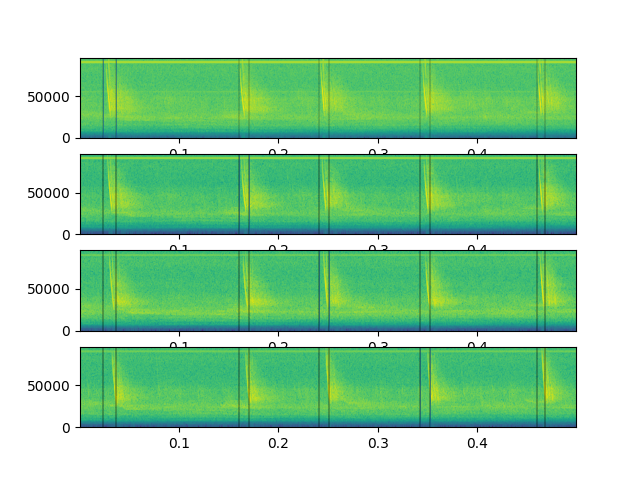

In [27]:
# Spectrogram of the cross-corr boundaries
plt.figure()
ax= plt.subplot(411)
plt.specgram(audio[:,0], Fs=fs)
for each in manual_crosscor_boundaries[0]:
    plt.vlines(each, 0, fs*0.5, linewidth=0.4)
    
for each in crosscor_boundaries:
    plt.vlines(each, 0, fs*0.5, linewidth=0.2, color='k', alpha=1)

for i in range(2,5):
    plt.subplot(410+i, sharex=ax)
    plt.specgram(audio[:,i-1], Fs=fs)
    for each in manual_crosscor_boundaries[i-1]:
        plt.vlines(each, 0, fs*0.5, linewidth=0.4)
        for each in manual_crosscor_boundaries:
            plt.vlines(each, 0, fs*0.5, linewidth=0.2, color='k', alpha=1)

In [28]:
reference_ch = 3

all_tdoas = {}
for i,each_common in enumerate(crosscor_boundaries):
    start, stop = each_common
    start_sample, stop_sample = int(start*fs), int(stop*fs)
    tdoas = measure_tdoa(audio[start_sample:stop_sample,:], fs, ref_channel=reference_ch)
    all_tdoas[i] = tdoas

In [29]:
all_tdoas

{0: array([-0.00592969, -0.00439323, -0.0026276 ]),
 1: array([-0.00211979, -0.00410417, -0.00246875]),
 2: array([-0.00336458, -0.00389583, -0.00236979]),
 3: array([-0.00498958, -0.00367187, -0.00219271]),
 4: array([-0.00220833, -0.00336979, -0.00198958])}

In [30]:
vsound = 340.0
all_positions = []
num_rows = mic_positions.shape[0]-1
calculated_positions = np.zeros((len(all_tdoas.keys()), 3,2))
for det_number, tdoas in all_tdoas.items():
        d = (vsound*tdoas).reshape(-1,1)
        solution1, solution2 = sr87.schau_robinson_solution(mic_positions, d)
        calculated_positions[det_number,:,0] = solution1
        calculated_positions[det_number,:,1] = solution2
        #calculated_positions[det_number,:] = pos    

c:\users\tbeleyur\documents\research_repos\batracker\batracker\localisation\schau_robinson_1987.py:143: RuntimeWarning: invalid value encountered in sqrt
  squareroot_term = np.sqrt(b**2 - 4*a*c)


In [31]:
calculated_positions[:,:,0]

array([[        nan,         nan,         nan],
       [-0.11615799,  0.        , -0.48230739],
       [-0.02224393,  0.        , -0.61502168],
       [ 0.0524518 ,  0.        , -0.68150181],
       [-0.10757863,  0.        , -0.37056916]])

In [32]:
calculated_positions[:,:,1]

array([[        nan,         nan,         nan],
       [-1.09489353,  0.        ,  1.3612319 ],
       [-1.18826014,  0.        ,  1.53262247],
       [-1.66796795,  0.        ,  2.2757293 ],
       [-0.89030026,  0.        ,  1.03443878]])

In [33]:
import scipy.spatial as spl

In [34]:
spl.distance_matrix(calculated_positions[:,:,0], calculated_positions[:,:,0])

array([[       nan,        nan,        nan,        nan,        nan],
       [       nan, 0.        , 0.16258208, 0.26097448, 0.11206711],
       [       nan, 0.16258208, 0.        , 0.0999953 , 0.25891899],
       [       nan, 0.26097448, 0.0999953 , 0.        , 0.34969823],
       [       nan, 0.11206711, 0.25891899, 0.34969823, 0.        ]])

In [35]:
mic_xyz

,x,y,z
0,-0.162229,-3.854878,0.097387
1,-1.084803,-3.256231,-0.437829
2,0.278436,-4.036286,-0.544380
3,-0.118366,-3.985202,1.299513


<IPython.core.display.Javascript object>


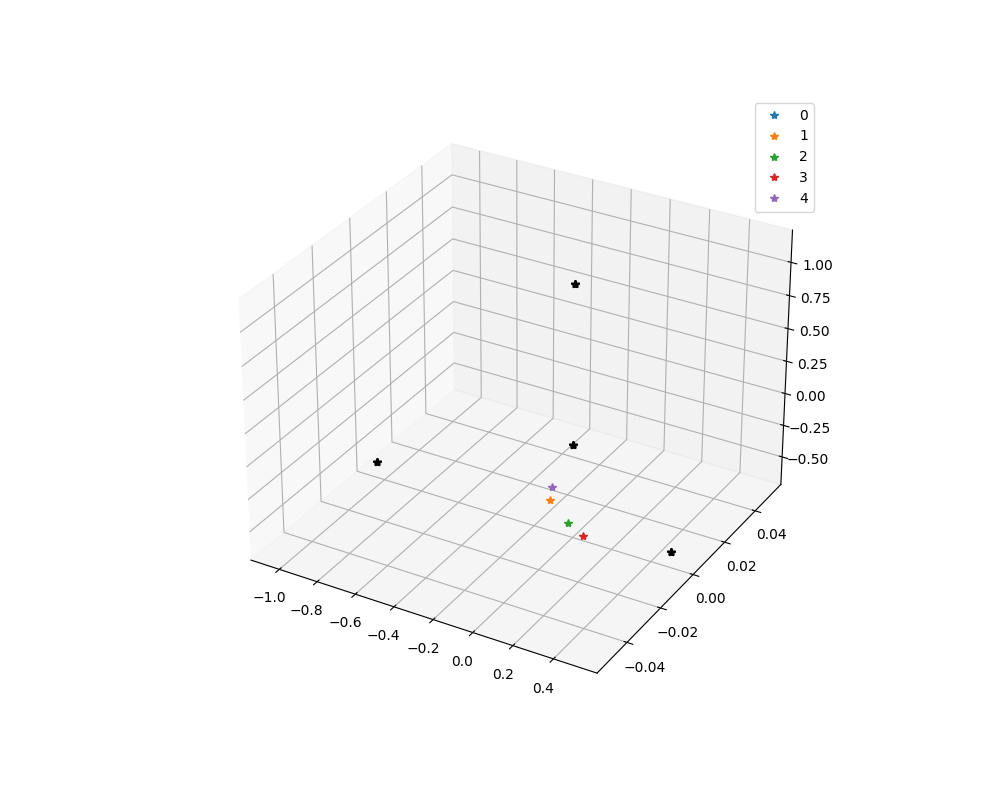

In [36]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
#ax.view_init(elev=24, azim=16)
for each in range(len(all_tdoas.keys())):
    ax.plot(calculated_positions[each,0,0], calculated_positions[each,1,0],
            calculated_positions[each,2,0],'*', label=str(each))
plt.legend()


for each in range(4):
    ax.plot(mic_positions[:,0],mic_positions[:,1],mic_positions[:,2],'k*')

This is odd -- the acoustic tracking suggests the opposite of what the video seems to show (35000.TMC) -- need to get this figured out. 

### Compare the acoustic tracking positions for the first 0.5 seconds to the video tracking from the 1st 9 frames

In [45]:
bat_positions = pd.read_csv('video_tracking/DLTdv7_data_2018-07-28_P00_35000xyzpts.csv')
firstbatframes = bat_positions.loc[:,:'pt1_Z']
firstbatframes.columns = ['x','y','z']
#first9frames['t'] = firs
firstbatframes

,x,y,z
0,0.337492,-0.377541,0.202593
1,0.354718,-0.507088,0.233293
2,0.379908,-0.683907,0.258009
3,0.404210,-0.825023,0.254202
4,0.423145,-0.992558,0.253135
...,...,...,...
371,NaN,NaN,NaN
372,NaN,NaN,NaN
373,NaN,NaN,NaN
374,NaN,NaN,NaN


In [56]:
bat2frames = bat_positions.loc[:,'pt2_X':'pt2_Z']
bat2frames.columns = ['x','y','z']

bat3frames = bat_positions.loc[:,'pt3_X':'pt3_Z']
bat3frames.columns = ['x','y','z']

In [59]:
bat3frames[~pd.isna(bat3frames['x'])]

,x,y,z
71,2.859443,0.317074,-0.989779
72,2.694945,0.229578,-0.938026
73,2.543151,0.159314,-0.903389
74,2.432755,0.048352,-0.865923


<IPython.core.display.Javascript object>


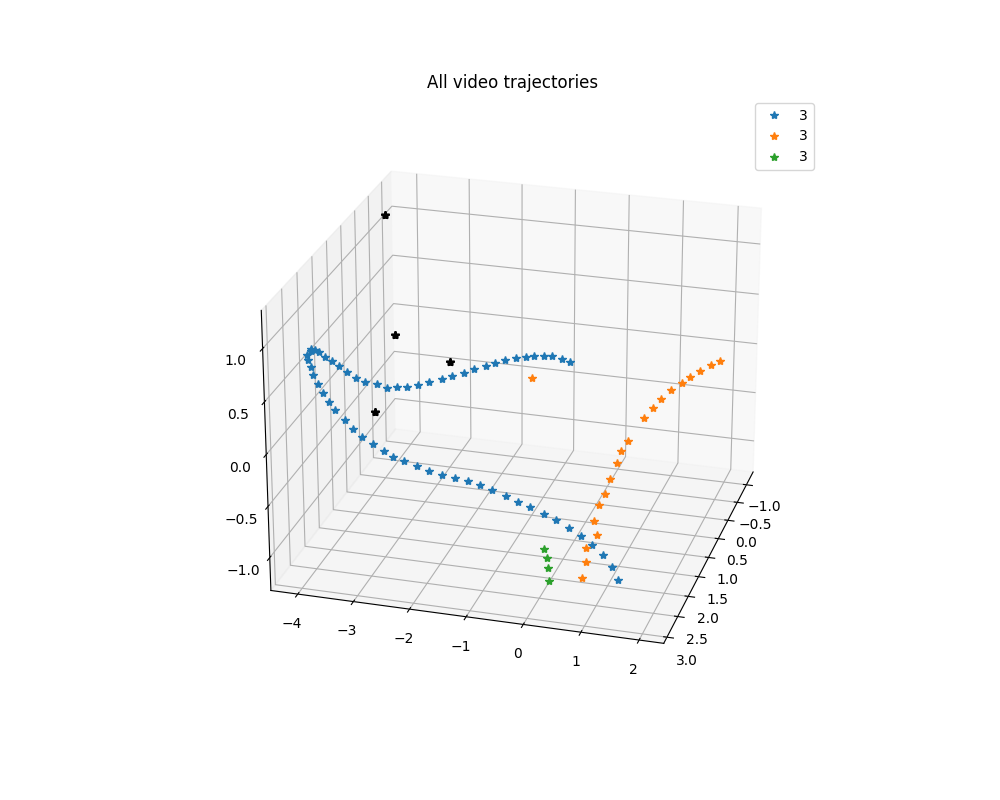

In [61]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
plt.title('All video trajectories')
ax.view_init(elev=24, azim=16)
for df in [firstbatframes, bat2frames, bat3frames]:
    ax.plot(df['x'], df['y'], df['z'],'*', label=str(each))
plt.legend()

for each in range(4):
    ax.plot(mic_xyz['x'],mic_xyz['y'],mic_xyz['z'],'k*')

In [39]:
for i in range(first9frames.shape[0]-1):
    print(spl.distance.euclidean(first9frames.loc[i,:],first9frames.loc[i+1,:])/0.04)

3.3561185062695555
4.507658449586105
3.581096716527631
4.215125216037481
3.5091251282370943
4.175096184745326
4.611555152616632
4.338127201051161
4.050341612984638


### Quick Summary: Video tracking Works, Acoustic tracking fail for 2018-07-28